In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import glob
import cv2
import random

import tensorflow as tf

#print versions
print('tensorflow version',tf.__version__)

tensorflow version 2.4.1


In [ ]:
def print_results(y_test, y_pred):
    print('Accuracy   : {:.5f}'.format(accuracy_score(y_pred , y_test))) 
    print('AUC        : {:.5f}'.format(roc_auc_score(y_test , y_pred)))
    print('Precision  : {:.5f}'.format(precision_score(y_test , y_pred)))
    print('Recall     : {:.5f}'.format(recall_score(y_test , y_pred)))
    print('F1         : {:.5f}'.format(f1_score(y_test , y_pred)))
    print('Confusion Matrix : \n', confusion_matrix(y_test, y_pred))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load Data

In [ ]:
train_path = '/content/drive/My Drive/DataSet/chest_xray/train'
val_path = '/content/drive/My Drive/DataSet/chest_xray/test'
test_path = '/content/drive/My Drive/DataSet/chest_xray/test'

In [ ]:
train_files_original = glob.glob(train_path+'/*/*')
val_files_original = glob.glob(val_path+'/*/*')
test_files = glob.glob(test_path+'/*/*')

print('number of train samples across classes:', len(train_files_original))
print('number of val samples across classes:', len(val_files_original))
print('number of test samples across classes:', len(test_files))

number of train samples across classes: 5216
number of val samples across classes: 624
number of test samples across classes: 624


## 2. Process Inputs

As you can see, there are only 16 samples in validation set (~0.3%), we would prefer to have a greater proportion of samples included in validation set. Let's create a 80:30 split between train and test

In [ ]:
files = np.unique(train_files_original + val_files_original)
train_files, val_files = train_test_split(files, test_size=0.3, shuffle=True)

print('number of train samples:', len(train_files))
print('number of val samples:', len(val_files))

number of train samples: 4088
number of val samples: 1752


Check distribution of classes in train set

In [ ]:
count_normal = len([x for x in train_files if 'NORMAL' in x])
count_pneumonia = len([x for x in train_files if 'PNEUMONIA' in x])

print('Count of NORMAL images in train:', count_normal)
print('Count of PNEUMONIA images in train:', count_pneumonia)

Count of NORMAL images in train: 1082
Count of PNEUMONIA images in train: 3006


There appears to be imbalance in number of normal and pneumonia cases, we'll handle it through class_weight during model building

In [ ]:
IMG_SIZE = 180
def process_inputs(files_list):
  data = []
  for file in files_list:
    try:
      # figure out label
      parts = file.split('/')
      assert parts[-2] in ['NORMAL', 'PNEUMONIA']
      label = 1 if parts[-2] == "PNEUMONIA" else 0

      # figure out image pixel array
      img_arr = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
      resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    except Exception as e:
      raise Exception(e)
    data.append([resized_arr, label])
  return np.array(data)

In [ ]:
train = process_inputs(train_files)
val = process_inputs(val_files)
test = process_inputs(test_files)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

In [ ]:
# see one sample
x_train[0]

array([[216, 210, 200, ...,  17,  16,   8],
       [212, 201, 197, ...,  17,  16,  37],
       [212, 204, 194, ...,  14,  17,  13],
       ...,
       [168, 165, 124, ..., 200, 201, 203],
       [181, 192, 135, ..., 201, 200, 202],
       [185, 160, 119, ..., 200, 199, 204]], dtype=uint8)

The images originally have values that range from [0, 255]. CNNs work better with smaller numbers so we will scale this down.

In [ ]:
x_train = np.array(x_train) / 255.
x_val = np.array(x_val) / 255.
x_test = np.array(x_test) / 255.

In [ ]:
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

## 3. Visualize

label =  1


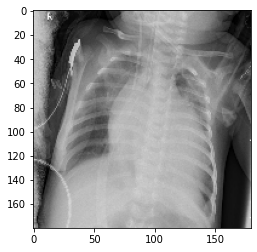

In [ ]:
plt.imshow(x_train[0].reshape(180,180), cmap='gray')
print('label = ', y_train[0])

In [ ]:
print(len(x_train))
print(len(x_val))
print(len(x_test))

4088
1752
624


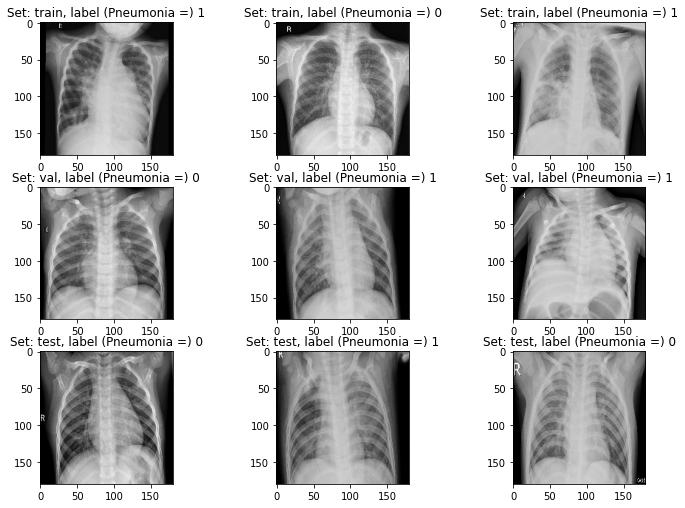

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 7))
ax = ax.ravel()
plt.tight_layout()

for i in range(3):
  random_index = random.randint(0, min(len(x_train), len(x_val), len(x_test)))
  ax[i].imshow(x_train[random_index].reshape(180,180), cmap='gray')
  ax[i].set_title('Set: train, label (Pneumonia =) {}'.format(y_train[random_index]))

  ax[i+3].imshow(x_val[random_index].reshape(180,180), cmap='gray')
  ax[i+3].set_title('Set: val, label (Pneumonia =) {}'.format(y_val[random_index]))

  ax[i+6].imshow(x_test[random_index].reshape(180,180), cmap='gray')
  ax[i+6].set_title('Set: test, label (Pneumonia =) {}'.format(y_test[random_index]))

## 4. Build and Train CNN

To make the code easier to understand, let's define functions to add Conv layers and Dense layers

In [ ]:
def conv_block(filters):
  block = tf.keras.Sequential([
    tf.keras.layers.SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
    tf.keras.layers.SeparableConv2D(filters, (3,3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),    
  ])
  return block

In [ ]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
  ])
  return block

In [ ]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    conv_block(32),
    conv_block(64),
    
    conv_block(128),
    tf.keras.layers.Dropout(0.2),

    conv_block(256),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    dense_block(256, 0.7),
    dense_block(128, 0.5),
    dense_block(64, 0.3),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  return model

While loading data we noticed that there is a class imbalance between normal vs pneumonia samples - pneumonia samples are approximately 3x normal samples. Let's utilize 'class_weight' to counter class imbalance

In [ ]:
weight_for_normal = len(x_train) / (2 * count_normal)
weight_for_pneumonia = len(x_train) / (2 * count_pneumonia)

class_weight = {0:weight_for_normal, 1:weight_for_pneumonia}

print('weight for class 0 (normal): {:.3f}'.format(weight_for_normal))
print('weight for class 1 (pneumonia): {:.3f}'.format(weight_for_pneumonia))

weight for class 0 (normal): 1.868
weight for class 1 (pneumonia): 0.683


Since normal samples are less, there will be a higher penalty (proportional to weight) to mis-classify normal sample

In [ ]:
# compile a vanilla model

model_vanilla = build_model()

metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model_vanilla.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
epochs = 60
batch_size = 100

In [ ]:
history_vanilla = model_vanilla.fit(
    x=x_train, 
    y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_val,y_val), 
    class_weight=class_weight
)

Epoch 1/60
41/41 [==============================] - 284s 7s/step - loss: 0.7483 - accuracy: 0.6131 - precision: 0.8486 - recall: 0.5810 - val_loss: 0.6378 - val_accuracy: 0.7255 - val_precision: 0.7255 - val_recall: 1.0000
Epoch 2/60
41/41 [==============================] - 276s 7s/step - loss: 0.4115 - accuracy: 0.8311 - precision: 0.9584 - recall: 0.8054 - val_loss: 0.5889 - val_accuracy: 0.7255 - val_precision: 0.7255 - val_recall: 1.0000
Epoch 3/60
41/41 [==============================] - 277s 7s/step - loss: 0.3033 - accuracy: 0.8730 - precision: 0.9625 - recall: 0.8580 - val_loss: 0.6056 - val_accuracy: 0.7255 - val_precision: 0.7255 - val_recall: 1.0000
Epoch 4/60
41/41 [==============================] - 275s 7s/step - loss: 0.2258 - accuracy: 0.9156 - precision: 0.9671 - recall: 0.9165 - val_loss: 0.6668 - val_accuracy: 0.7255 - val_precision: 0.7255 - val_recall: 1.0000
Epoch 5/60
41/41 [==============================] - 275s 7s/step - loss: 0.2001 - accuracy: 0.9248 - precisi

In [ ]:
epochs_array = [i for i in range(epochs)]
fig, ax = plt.subplots(1,3)
train_precision = history_vanilla.history['precision']
train_recall = history_vanilla.history['recall']
train_loss = history_vanilla.history['loss']

val_precision = history_vanilla.history['val_precision']
val_recall = history_vanilla.history['val_recall']
val_loss = history_vanilla.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs_array, train_loss, 'g-o', label='Training Loss')
ax[0].plot(epochs_array, val_loss, 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].plot(epochs_array, train_precision, 'go-', label='Training Precision')
ax[1].plot(epochs_array, val_precision, 'ro-', label='Validation Precision')
ax[1].set_title('Training & Validation Precision')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].grid(True)

ax[2].plot(epochs_array, train_recall, 'go-', label='Training Recall')
ax[2].plot(epochs_array, val_recall, 'ro-', label='Validation Recall')
ax[2].set_title('Training & Validation Recall')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Recall')
ax[2].grid(True)

plt.show()

NameError: ignored

In [ ]:
predictions = model_vanilla.predict(x=x_test)
y_pred = np.round(predictions).reshape(1,-1)[0]

In [ ]:
print_results(y_test, y_pred)

Accuracy   : 0.94551
AUC        : 0.94872
Precision  : 0.97594
Recall     : 0.93590
F1         : 0.95550
Confusion Matrix : 
 [[225   9]
 [ 25 365]]


The recall on test set is impressive - and is according to our preference, we would like to identify all pneumonia cases. Let's fine tune the model to see if precision could be better...

### 4.1. Fine Tune Model

In [ ]:
# compile fine tuned model

model_ft = build_model()

metrics = [
  'accuracy', 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('xray_model.h5', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1, restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
epochs = 50
batch_size = 64

In [ ]:
history_ft = model_ft.fit(
    x=x_train, 
    y=y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(x_val,y_val), 
    class_weight=class_weight,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/50
56/64 [=========================>....] - ETA: 33s - loss: 0.6739 - accuracy: 0.6640 - precision: 0.8615 - recall: 0.6378

KeyboardInterrupt: ignored

In [ ]:
epochs_array = [i for i in range(len(history_ft.history['accuracy']))]
fig, ax = plt.subplots(1,3)
train_precision = history_ft.history['precision']
train_recall = history_ft.history['recall']
train_loss = history_ft.history['loss']

val_precision = history_ft.history['val_precision']
val_recall = history_ft.history['val_recall']
val_loss = history_ft.history['val_loss']
fig.set_size_inches(20,5)

ax[0].plot(epochs_array, train_loss, 'g-o', label='Training Loss')
ax[0].plot(epochs_array, val_loss, 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

ax[1].plot(epochs_array, train_precision, 'go-', label='Training Precision')
ax[1].plot(epochs_array, val_precision, 'ro-', label='Validation Precision')
ax[1].set_title('Training & Validation Precision')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Precision')
ax[1].grid(True)

ax[2].plot(epochs_array, train_recall, 'go-', label='Training Recall')
ax[2].plot(epochs_array, val_recall, 'ro-', label='Validation Recall')
ax[2].set_title('Training & Validation Recall')
ax[2].legend()
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Recall')
ax[2].grid(True)
plt.show()

In [ ]:
predictions = model_ft.predict(x=x_test)
y_pred = np.round(predictions).reshape(1,-1)[0]

In [ ]:
print_results(y_test, y_pred)

As seen above, our fine tuned model is able to correctly identify almost all pneumonia positive cases (~99.5% recall). Precision has improved as well - on the flip side, ~74% precision means that out of all patients diagnosed as pneumoniatic by our model, a false alarm is generated for ~26% healthy patients. In an ideal situation, we would prefer even higher precision keeping recall at current levels, but there is a trade off between precision and recall...If you have thoughts about how to improve precision while keeping high recall, please let me know in comments.

### 4.2. Look at incorrectly classified cases


In [ ]:
incorrect = np.nonzero(y_test != y_pred)[0]

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15,15))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.25, hspace=0.75)
plt.tight_layout()
i = 0
for c in incorrect[:6]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].imshow(x_test[c].reshape(IMG_SIZE,IMG_SIZE), cmap='gray', interpolation='none')
    ax[i].set_title('Predicted Class: {}, Actual Class: {}'.format(y_pred[c], y_test[c]))
    i += 1 

Checklist for me to try in future:
1. Use Data Augmentation techniques as an alternative to class_weight to handle class imbalance
2. Try other optimizers
3. Transfer Learning

Lastly, here are the resources / notebooks I referred while building my model:
1. https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays/comments
2. https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8
3. https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

In [ ]:
first commit 